# PanSTARRS $(g-z)$ analysis 2025
Version 3 Jan 2025, J. Jensen; corrected annulus limits (14 Dec 2024); corrected variable name R1 (3 Jan 2025)

Compute the colors by taking the magnitudes in g and z of the total of the good pixels in annuli first and subtracting, not computing colors individually by pixel and then averaging like before.

The uncertainties are computed from the variance images for the same pixels. Regions with rms > threshold (0.5 mag) are excluded and no g-z values are reported (NaN).

I found that subtracting residual sky did not affect good measurements, and since the sky value subtracted is not known per pixel anyway (and is quite chaotic), it's better not to add to the uncertainty by further subtracting the residual sky.

I checked to see if limiting the pixels to +/- 2*rms within an annulus would help. It didn't change anything and the reduced number of pixels actually increased the uncertainty. I dropped that step from this version.

The photometric uncertainty and extinction correction uncertainty are added in quadrature.

Galaxy list updated Dec 2024

In [1]:
### Install the required python packages
import sys, os
import datetime

In [2]:
from settings import *

In [3]:
sys.path.insert(0, PYSBF_PATH)

import warnings
from pysbf import *
from IPython.display import display, Markdown, clear_output

%matplotlib widget
warnings.filterwarnings('ignore')

Matplotlib created a temporary cache directory at /tmp/matplotlib-befhvfgf because the default path (/home/sbf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
# Name convention for manually-created masks, if any:
PS_manual = 'ps.mask'

configFolder = CONFIG_FOLDER + "sextractor/"
resetSEmask = False

# If the automatic masking procedure using SExtractor fails, try using the manual PS line mask only (PSonly=True)
PSonly = False

version = "PanSTARRS-gz 2025-01-03"

## Photometric uncertainty

In [5]:
# Fractional uncertainty to assign to extinction values
extfrac = 0.1

# Magnier et al. 2020: the systematic noise floor for sigma(g)=0.014 mag, and sigma(z)=0.015 mag
# photouncert from Schlafly et al. 2012, added in quadrature = 0.013 mag.
photouncertg = 0.008
photouncertz = 0.0107

## Object Initialization

In [6]:
now = datetime.now()

# R1 is the radial region to fit with elliprof.
# Values around 80 are good for small galaxies, 100 for larger ones.
R1 = str(80)

# Calibration sample from 2019 for comparison; using existing masks (mostly)
# PS_root = '/Users/Joe/data/PScolors-2024/'
#- = corrected radii, 14 Dec 2024

name = "u12517" ; PSonly=True; R1=str(80)

In [7]:
# This flag should be set to True while generating and fixing masks.
# Comment out this line once the masks are good, for re-running later (False by default).
# resetSEmask = True

### Get Galaxy Info

You can enter galaxy name in a foramt that is recognized ny NED. The coordinates and other info are automatically extracted from NED.

`reference`: http://ned.ipac.caltech.edu/forms/gmd.html

In [8]:
ned = get_ned_info([name])
if ned is not None:
    ra, dec = ned.iloc[0]["ra_dec"]
ned

,Row,Input Object Name,Object Name,RA,Dec,Gal_J2000.0,Gal_LON,Extinction,&_Heiles,PS1_g,PS1_r,PS1_i,PS1_z,PS1_y,Row,ra_dec
U12517,1,U12517,UGC 12517,23h19m54.47s,+43d57m27.8s,106.013,-15.886,0.753,0.592,0.424,0.314,0.247,0.203,0.437,1,"(349.9769583333333, 43.95772222222222)"


In [9]:
# For some reason this galaxy didn't work with the coords request from NED
if name == "ic2597":
    ra = 159.447716
    dec = -27.081695
# The NED coordinates for these are between the main galaxy and a satellite    
if name == "n7242":
    ra = 333.91436
    dec = 37.2985915
if name == "n5222":
    ra = 203.7330204
    dec = 13.7420058
if name == "n1684":
    ra = 73.1297411
    dec = -3.1060132
if name == "n0997":
    ra = 39.3102843
    dec = 7.3056710

In [10]:
if ned is not None:
    objName = ned.iloc[0]["Object Name"]
    try:
        pgc = getPGCid(objName.replace(" ", "%20"))
    except:
        pgc = "None"

print(name," = PGC", pgc)

u12517  = PGC None


In [11]:
PS_IN, PS_OUT

('/home/sbf/ps_data_in/', '/home/sbf/ps_data_out/')

In [12]:
PS_root = '/Users/Joe/data/wfc3-17436/PS/'

In [13]:
# Set up file names for masks and output directory
outFolder = PS_OUT + name + '/PS_Outputs_' + name + '/'
createDir(outFolder)

g_fits = PS_IN + name + '/' + name + '_g.fits'
z_fits = PS_IN + name + '/' + name + '_z.fits'
g_var = PS_IN + name + '/' + name + '_gwt.fits'
z_var = PS_IN + name + '/' + name + '_zwt.fits'

PS_mask = outFolder + '/' + name + '.mask' 

PS_skymask = configFolder + 'pssky.mask'
PS_circlemask = configFolder + 'pscircle.mask'
PS_lines = PS_IN + name + '/' + name + PS_manual

size = 3000   # size in pixels (0.25 arcsec/pixel)

In [14]:
# If using only the PSmask:
if PSonly==True:
    xcmd("cp "+PS_lines+" "+PS_mask, verbose=False)
    resetSEmask = False
    print('Using the PS mask only; please make sure all extraneous objects are masked.')

Using the PS mask only; please make sure all extraneous objects are masked.


cp: cannot stat '/home/sbf/ps_data_in/u12517/u12517ps.mask': No such file or directory


### Look up coordinates and Galactic extinction in NED

In [15]:
df_extinction = get_extinction(ra, dec)
df_extinction.set_index("Bandpass", inplace=True)

PS1_rows = [band for band in df_extinction.index.values if "PS1" in band]

df_extinction.loc[PS1_rows]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4294    0  4294    0     0  14746      0 --:--:-- --:--:-- --:--:-- 14806


,Central Wavelength,The Galactic extinction,Refcode of the publications
Bandpass,,,
PS1 g,0.49,0.592,2011ApJ...737..103S
PS1 r,0.62,0.424,2011ApJ...737..103S
PS1 i,0.75,0.314,2011ApJ...737..103S
PS1 z,0.87,0.247,2011ApJ...737..103S
PS1 y,0.97,0.203,2011ApJ...737..103S
PS1 w,0.62,0.437,2011ApJ...737..103S


In [16]:
extinctions = df_extinction["The Galactic extinction"]

gext = extinctions["PS1 g"]
zext = extinctions["PS1 z"]
# Don't add them in quadrature because the extinction corrections are not independent
sigmaext = extfrac*(gext-zext)
# sigmaext = (extfrac*gext)**2 + (extfrac*zext)**2

print("Galactic Extinction (PS1 g): ", gext)
print("Galactic Extinction (PS1 z): ", zext)
print("(g-z) extinction uncertainty: %.3f" % sigmaext)


Galactic Extinction (PS1 g):  0.592
Galactic Extinction (PS1 z):  0.247
(g-z) extinction uncertainty: 0.034


### Download PanSTARRS1 files if they don't already exist

In [17]:
## downloading PS1 fits files 
def download_PS1(ra, dec, size, filter='g', format='fits', outFits="PS1.fits", imagetypes="stack,stack.wt"):

    fitsurl = geturl(ra, dec, size=int(size), filters=filter, format=format, imagetypes=imagetypes)
    print(fitsurl)
    xcmd("curl '"+fitsurl[0]+"' -o "+outFits, verbose=False)
    print('Downloaded ... ' + outFits)
    
if not os.path.exists(g_fits):
    download_PS1(ra, dec, size, filter='g', outFits=g_fits, imagetypes="stack")
if not os.path.exists(z_fits):
    download_PS1(ra, dec, size, filter='z', outFits=z_fits, imagetypes="stack")
if not os.path.exists(g_var):
    download_PS1(ra, dec, size, filter='g', outFits=g_var, imagetypes="stack.wt")
if not os.path.exists(z_var):
    download_PS1(ra, dec, size, filter='z', outFits=z_var, imagetypes="stack.wt")

print("g-band fits file: " + g_fits)
print("z-band fits file: " + z_fits)
print("g-band weight file: " + g_var)
print("z-band weight file: " + z_var)
if os.path.exists(PS_lines):
   print("Input mask: ",PS_lines) 

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header
gexp = hdr["EXPTIME"]

hdul = fits.open(z_fits)
hdr = hdul[0].header     # header
zexp = hdr["EXPTIME"]

print("g-band exposure time (sec): " + str(gexp))
print("z-band exposure time (sec): " + str(zexp))


['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=349.9769583333333&dec=43.95772222222222&size=3000&format=fits&imagetypes=stack&red=/rings.v3.skycell/2223/093/rings.v3.skycell.2223.093.stk.g.unconv.fits']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file /home/sbf/ps_data_in/u12517/u12517_g.fits: 
  0 34.3M    0  7900    0     0   8108      0  1:14:02 --:--:--  1:14:02  8110
curl: (23) Failure writing output to destination


Downloaded ... /home/sbf/ps_data_in/u12517/u12517_g.fits
['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=349.9769583333333&dec=43.95772222222222&size=3000&format=fits&imagetypes=stack&red=/rings.v3.skycell/2223/093/rings.v3.skycell.2223.093.stk.z.unconv.fits']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file /home/sbf/ps_data_in/u12517/u12517_z.fits: 
  0 34.3M    0  7900    0     0   8597      0  1:09:49 --:--:--  1:09:49  8596
curl: (23) Failure writing output to destination


Downloaded ... /home/sbf/ps_data_in/u12517/u12517_z.fits
['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=349.9769583333333&dec=43.95772222222222&size=3000&format=fits&imagetypes=stack.wt&red=/rings.v3.skycell/2223/093/rings.v3.skycell.2223.093.stk.g.unconv.wt.fits']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file 
  0 34.3M    0  7897    0     0   8448      0  1:11:03 --:--:--  1:11:03  8445
curl: (23) Failure writing output to destination


Downloaded ... /home/sbf/ps_data_in/u12517/u12517_gwt.fits
['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=349.9769583333333&dec=43.95772222222222&size=3000&format=fits&imagetypes=stack.wt&red=/rings.v3.skycell/2223/093/rings.v3.skycell.2223.093.stk.z.unconv.wt.fits']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file 
  0 34.3M    0  7897    0     0   8014      0  1:14:54 --:--:--  1:14:54  8017
curl: (23) Failure writing output to destination


Downloaded ... /home/sbf/ps_data_in/u12517/u12517_zwt.fits
g-band fits file: /home/sbf/ps_data_in/u12517/u12517_g.fits
z-band fits file: /home/sbf/ps_data_in/u12517/u12517_z.fits
g-band weight file: /home/sbf/ps_data_in/u12517/u12517_gwt.fits
z-band weight file: /home/sbf/ps_data_in/u12517/u12517_zwt.fits


FileNotFoundError: [Errno 2] No such file or directory: '/home/sbf/ps_data_in/u12517/u12517_g.fits'

## Subtract the galaxy and make the mask

This next block is for making PanSTARRS masks using Source Extractor.
These masks are usually insufficient because they do not take out the PanSTARRS stripes and defects.
They should be manually edited. Please edit the mask, save it as '{name}ps.mask' and rerun the notebook.

In [ ]:
# create residual images for Source Extractor
monsta_script = """
    rd 1 '"""+g_var+"""'
    rd 2 '"""+z_var+"""'
    clip 1 nan=0
    clip 2 nan=0
    rd 10 '"""+PS_circlemask+"""'
    mi 1 10
    mi 2 10
    box 1 nc=550 nr=550 cc=1500 cr=1500
    wind 1 box=1
    wind 2 box=1
    wd 1 '"""+outFolder+name+"""gvar.nonan'
    wd 2 '"""+outFolder+name+"""zvar.nonan'
    
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    wd 1 '"""+outFolder+name+"""g.nonan'
    wd 2 '"""+outFolder+name+"""z.nonan'

    set nr="""+R1+"""/10$nint
    string nr '%i2.0' nr
    cop 3 1
    cop 4 2
    elliprof 3 model rmstar x0=1500 y0=1500 r0=7 r1="""+R1+""" nr=nr niter=5
    elliprof 4 model rmstar x0=1500 y0=1500 r0=7 r1="""+R1+""" nr=nr niter=5
    cop 5 1
    si 5 3
    cop 6 2
    si 6 4
    wd 5 '"""+outFolder+name+"""g.resid'
    wd 6 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+PS_circlemask+"""'
    ac 5 500.
    ac 6 500.
    mi 5 10
    mi 6 10
    wind 5 box=1
    wind 6 box=1
    wd 5 '"""+outFolder+name+"""g.zoom.resid'
    wd 6 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


In [ ]:
# Run Source Extractor if needed to generate the mask.
monsta_script = """
    rd 7 '"""+outFolder+"""/psg.obj'
    rd 8 '"""+outFolder+"""/psz.obj'
    di 7 7
    di 8 8
    mi 8 7
    wd 8 '"""+outFolder+name+""".mask' bitmap
"""
sestring_g = outFolder+name+'g.resid -c '+configFolder+'psg.inpar -CATALOG_NAME '+outFolder+'psg.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'psg.obj'
sestring_z = outFolder+name+'z.resid -c '+configFolder+'psz.inpar -CATALOG_NAME '+outFolder+'psz.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'psz.obj'
# print(sestring_g)
# print(sestring_z)

if resetSEmask or not os.path.exists(PS_mask):
    PS_mask = outFolder + name + '.mask'
    print('Creating ' + PS_mask + ' now.')
    print('Please edit it if necessary and save it as')
    print(PS_lines,'before proceeding.')
    ! sex {sestring_g}
    ! sex {sestring_z}
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""psg.inpar -CATALOG_NAME """+outFolder+"""/psg.cat -CHECKIMAGE_NAME """+outFolder+"""/psg.obj
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""psz.inpar -CATALOG_NAME """+outFolder+"""/psz.cat -CHECKIMAGE_NAME """+outFolder+"""/psz.obj
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


In [ ]:
# Multiply mask by the manual 'line' mask, if it exists
monsta_script = """
    rd 1 '"""+PS_mask+"""'
    rd 2 '"""+PS_lines+"""'
    mi 1 2
    wd 1 '"""+PS_mask+"""' bitmap
"""

if os.path.exists(PS_lines):
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

In [ ]:
# Multiply residual images by mask for display
monsta_script = """
    rd 1 '"""+outFolder+name+"""g.resid'
    rd 2 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+PS_mask+"""' bitmap 
    rd 11 '"""+PS_skymask+"""'
    mi 1 10
    mi 2 10
    cop 3 2
    mi 3 11
    wd 1 '"""+outFolder+name+"""g.resid'
    wd 2 '"""+outFolder+name+"""z.resid'
    wd 3 '"""+outFolder+name+"""sky.resid'
    rd 10 '"""+PS_circlemask+"""'
    ac 1 500.
    ac 2 500.
    mi 1 10
    mi 2 10
    box 1 nc=550 nr=550 cc=1500 cr=1500
    wind 1 box=1
    wind 2 box=1
    wd 1 '"""+outFolder+name+"""g.zoom.resid'
    wd 2 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


In [18]:
# Source Extractor test cell - uncomment to see if SExtractor is working.
# sex {sestring_g}

Text(0.5, 1.0, 'Sky Mask')

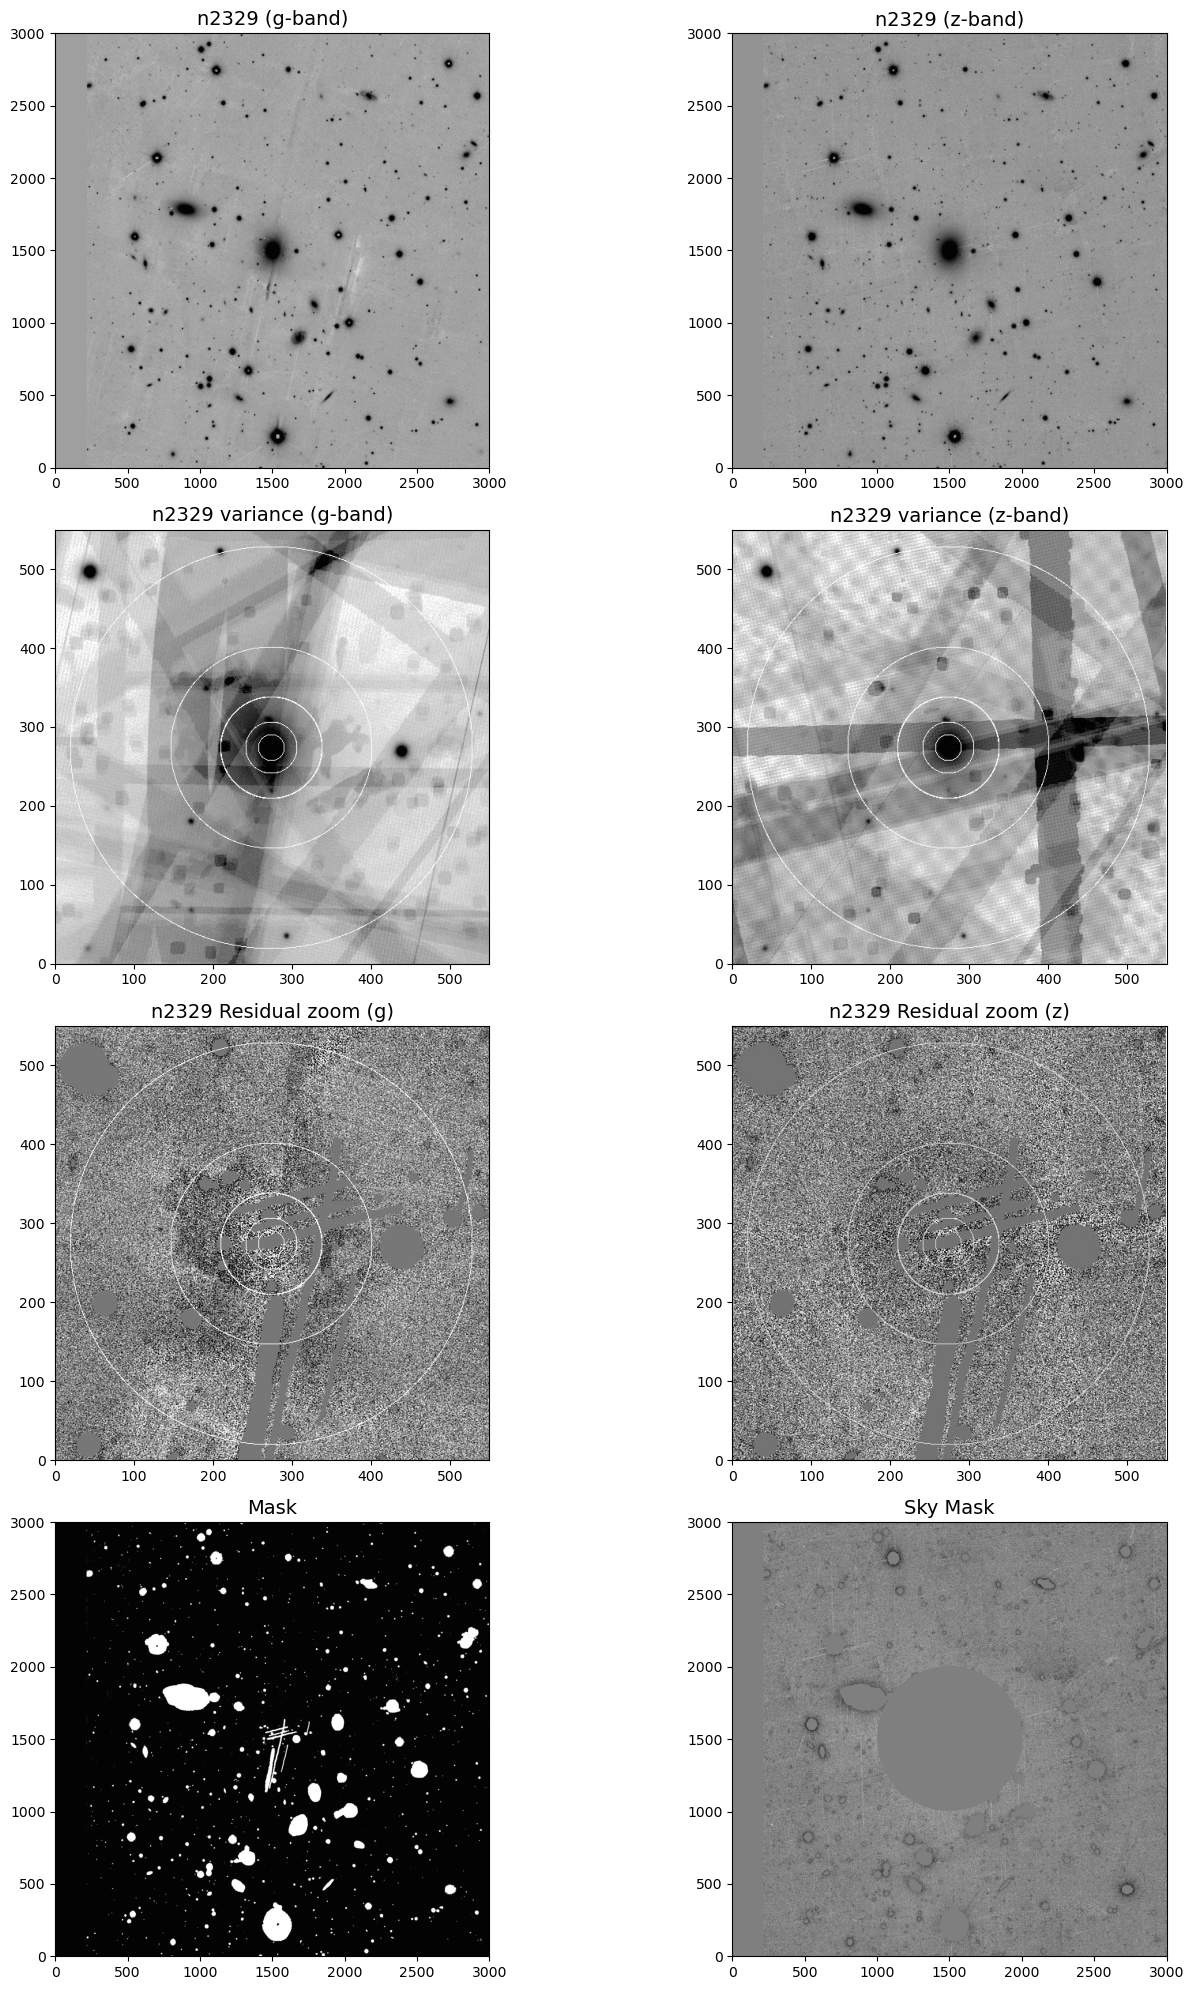

In [19]:
#PS_newmask = outFolder+name+".mask"

plt.figure(tight_layout=True, figsize=(15,20))

plt.subplot(421)
ax = plt.gca()
tv(outFolder+name+'g.nonan',ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)

plt.subplot(422)
ax = plt.gca()
tv(outFolder+name+'z.nonan',ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)

plt.subplot(423)
ax = plt.gca()
tv(outFolder+name+'gvar.nonan',ax=ax, options='sqrt')
ax.set_title(name + " variance (g-band)", fontsize=14)

plt.subplot(424)
ax = plt.gca()
tv(outFolder+name+'zvar.nonan',ax=ax, options='sqrt')
ax.set_title(name + " variance (z-band)", fontsize=14)

plt.subplot(427)
ax = plt.gca()
tv(PS_mask,ax=ax)
ax.set_title("Mask", fontsize=14)

plt.subplot(425)
ax = plt.gca()
tv(outFolder+name+"g.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (g)", fontsize=14)

plt.subplot(426)
ax = plt.gca()
tv(outFolder+name+"z.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (z)", fontsize=14)

plt.subplot(428)
ax = plt.gca()
tv(outFolder+name+"sky.resid",ax=ax)
#tv(PS_skymask,ax=ax)
ax.set_title("Sky Mask", fontsize=14)


## Set up the color information file

In [20]:
import json

def save_colors(monsta_log="monsta.log", version="unknown", date="unknown"):
    
    outdict = {}
    radii = []
    extinction = []
    background = []
    npix = []
    gz = []
    gzsigma = []
    qualityflag = []
    inputparams = []
    outdict["Code version"] = version
    outdict["Date and time run"] = date
    outdict["Radii"] = radii
    outdict["Extinction"] = extinction
    outdict["Residual background"] = background
    outdict["Number of unmasked pixels"] = npix
    outdict["g-z"] = gz
    outdict["g-z uncertainty"] = gzsigma
    outdict["Quality flags"] = qualityflag
    outdict["Input parameters"] = inputparams
    outdict["Name"] = name
    if pgc!="None":
        outdict["PGC"] = int(pgc)
    else:
        outdict["PGC"] = "None"
    outdict["Color"] = "PanSTARRS g-z"
    
    with open("monsta.log", "r") as f:
        lines = f.readlines()

    for l in lines:
        l0 = l.strip()
        l00 = l0.split()
        
        if l00:
            if "EXTG" in l0:
                extinction.append({"Extinction g (mag)": float(l00[1])})
            if "EXTZ" in l0:
                extinction.append({"Extinction z (mag)": float(l00[1])})
            if "SKYG" in l0:
                background.append({"Resid background g (DN)": float(l00[2])})
            if "SKYZ" in l0:
                background.append({"Resid background z (DN)": float(l00[2])})
            if "Unity" in l0:
                radii.append({"Average_radius (pix)": float(l00[6])})
            if "NPIXC0" in l0:
                npix.append({"Number of pixels in c0": float(l00[2])})
            if "NPIXC1" in l0:
                npix.append({"Number of pixels in c1": float(l00[2])})
            if "NPIXC2" in l0:
                npix.append({"Number of pixels in c2": float(l00[2])})
            if "NPIXC5" in l0:
                npix.append({"Number of pixels in c5": float(l00[2])})
            if "GZC0" in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c0": float('nan')})
                else:
                    gz.append({"(g-z) in c0": float(l00[2])})
            if "GZC1" in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c1": float('nan')})
                else:
                    gz.append({"(g-z) in c1": float(l00[2])})
            if "GZC2" in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c2": float('nan')})
                else:
                    gz.append({"(g-z) in c2": float(l00[2])})
            if "GZC5" in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c5": float('nan')})
                else:
                    gz.append({"(g-z) in c5": float(l00[2])})
            if "GZSIGC0" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c0": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c0": float(l00[2])})
            if "GZSIGC1" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c1": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c1": float(l00[2])})
            if "GZSIGC2" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c2": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c2": float(l00[2])})
            if "GZSIGC5" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c5": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c5": float(l00[2])})
            if "FLAGC0" in l0:
                qualityflag.append({"c0 flag": int(float(l00[2]))})
            if "FLAGC1" in l0:
                qualityflag.append({"c1 flag": int(float(l00[2]))})
            if "FLAGC2" in l0:
                qualityflag.append({"c2 flag": int(float(l00[2]))})
            if "FLAGC5" in l0:
                qualityflag.append({"c5 flag": int(float(l00[2]))})
            if "Photometric zero point uncertainty g" in l0:
                inputparams.append({"Photometric zero point uncertainty g (mag)": float(l00[5])})
            if "Photometric zero point uncertainty z" in l0:
                inputparams.append({"Photometric zero point uncertainty z (mag)": float(l00[5])})
            if "Extinction" in l0:
                extinction.append({"Extinction uncertainty (mag)": float(l00[2])})
            if "RMS" in l0:
                inputparams.append({"RMS limit for inclusion (mag)": float(l00[5])})

    json_name = outFolder+name+"_color_ps_gz.json"
    with open(json_name, 'w') as file:
        json_string = json.dumps(outdict, default=lambda o: o.__dict__, sort_keys=True, indent=2)
        file.write(json_string)

        print("Colors are stored in: ", json_name)

    return json_name


## Measure $(g-z)$

In [21]:
# create the color map and measure the color in monsta
now = datetime.now()

# buffer definitions for monsta:
# 1: g
# 2: wt_g (variance g)
# 3: z
# 4: wt_z
# 5: object+line mask
# 6: c0 annular mask
# 7: c1 annular mask
# 8: c2 annular mask
# 9: c5 annular mask
# 11: g (converted to mag)
# 12: sig g
# 13: z (converted to mag)
# 14: sig z

photvarg = photouncertg * photouncertg
photvarz = photouncertz * photouncertz
extvar = sigmaext * sigmaext

rmslimit = 0.5 # emperical limit for rms (in mag)

monsta_script = """
    string name '"""+name+"""'
    string gext '"""+str(gext)+"""'
    string zext '"""+str(zext)+"""'
    set flagc0=1 flagc1=1 flagc2=1 flagc5=1
    
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+g_var+"""'
    rd 3 '"""+z_fits+"""'
    rd 4 '"""+z_var+"""'
    clip 1 nan=0
    clip 2 nan=0
    clip 3 nan=0
    clip 4 nan=0
    dc 1 """+str(gexp)+"""
    dc 2 """+str(gexp)+"""    
    dc 3 """+str(zexp)+"""
    dc 4 """+str(zexp)+"""
    rd 5 '"""+PS_mask+"""'
    mi 1 5
    mi 2 5
    mi 3 5
    mi 4 5

    ! subtract residual background levels; the subtracted sky levels are not smooth, so let's ditch it for now
    rd 6 '"""+PS_skymask+"""'
    cop 7 1
    mi 7 6
    abx 7 all median median=skyg silent
    cop 7 3
    mi 7 6
    abx 7 all median median=skyz silent
    ! sc 1 skyg
    ! sc 3 skyz
    ! mi 1 5
    ! mi 3 5
    set skyg=0 skyz=0

    ! create annular masks
    open 6 nc=4096 nr=4096
    open 7 nc=4096 nr=4096
    open 8 nc=4096 nr=4096
    open 9 nc=4096 nr=4096
    fluc 6 5 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    fluc 7 5 mask x0=1500 y0=1500 r0=31.8 r1=63.5 a0=0 a1=360 ! c1
    fluc 8 5 mask x0=1500 y0=1500 r0=63.5 r1=127 a0=0 a1=360 ! c2
    fluc 9 5 mask x0=1500 y0=1500 r0=127 r1=254 a0=0 a1=360 ! c5

    ! Make color images for display and get the rms values to identify bad regions
    cop 11 1
    cop 12 3
    log 11
    log 12
    mc 11 -2.5
    mc 12 -2.5
    sc 11 """+str(gext)+"""
    sc 12 """+str(zext)+"""
    cop 13 11
    si 13 12
    mi 13 5
    wd 13 '"""+outFolder+name+"""gz.clr'
    cop 14 13
    mi 14 6
    wd 14 '"""+outFolder+"""tmpc0.fits'
    abx 14 all rms=rmsc0 silent
    cop 14 13
    mi 14 7
    wd 14 '"""+outFolder+"""tmpc1.fits'
    abx 14 all rms=rmsc1 silent
    cop 14 13
    mi 14 8
    wd 14 '"""+outFolder+"""tmpc2.fits'
    abx 14 all rms=rmsc2 silent
    cop 14 13
    mi 14 9
    wd 14 '"""+outFolder+"""tmpc5.fits'
    abx 14 all rms=rmsc5 silent
    rd 14 '"""+PS_circlemask+"""'
    ac 13 1.
    mi 13 14
    box 1 nc=550 nr=550 cc=1500 cr=1500
    wind 13 box=1
    wd 13 '"""+outFolder+name+"""gz.zoom.clr'
    close 11
    close 12
    close 13
    close 14
    if rmsc1>"""+str(rmslimit)+"""
        set flagc1=0
    end_if
    if rmsc2>"""+str(rmslimit)+"""
        set flagc2=0
    end_if
    if rmsc5>"""+str(rmslimit)+"""
        set flagc5=0
    end_if

    ! c0 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 6
    mi 12 6
    mi 13 6
    mi 14 6
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixc0=total/mean$nint
    else
        set npixc0=0
        set flagc0=0
    end_if
    if npixc0<400
        set flagc0=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flagc0=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flagc0=0
    end_if
    set gzc0=magg-magz*flagc0
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc0=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc0=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set sigz=tempmax-magz
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc0=sigg+sigz
    set gzsigc0=gzsigc0+"""+str(extvar)+"""$sqrt
    set gzsigc1=gzsigc0*flagc0

    ! c1 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 7
    mi 12 7
    mi 13 7
    mi 14 7
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixc1=total/mean$nint
    else
        set npixc1=0
        set flagc1=0
    end_if
    if npixc1<1800
        set flagc1=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flagc1=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flagc1=0
    end_if
    set gzc1=magg-magz*flagc1
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc1=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc1=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set sigz=tempmax-magz
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc1=sigg+sigz
    set gzsigc1=gzsigc1+"""+str(extvar)+"""$sqrt
    set gzsigc1=gzsigc1*flagc1

    ! c2 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 8
    mi 12 8
    mi 13 8
    mi 14 8
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixc2=total/mean$nint
    else
        set npixc2=0
        set flagc2=0
    end_if
    if npixc2<7300
        set flagc2=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flagc2=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flagc2=0
    end_if
    set gzc2=magg-magz*flagc2
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc2=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc2=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set sigz=tempmax-magz
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc2=sigg+sigz
    set gzsigc2=gzsigc2+"""+str(extvar)+"""$sqrt
    set gzsigc2=gzsigc2*flagc2

    ! c5 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 9
    mi 12 9
    mi 13 9
    mi 14 9
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixc5=total/mean$nint
    else
        set npixc5=0
        set flagc5=0
    end_if
    if npixc5<30000
        set flagc5=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flagc5=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flagc5=0
    end_if
    set gzc5=magg-magz*flagc5
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc5=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flagc5=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set flagc5=0
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc5=sigg+sigz
    set gzsigc5=gzsigc5+"""+str(extvar)+"""$sqrt
    set gzsigc5=gzsigc5*flagc5

    printf 'Galaxy: {name}'
    printf 'EXTG: {gext}'
    printf 'EXTZ: {zext}'
    typ skyg,skyz
    typ npixc0,npixc1,npixc2,npixc5
    typ flagc0,flagc1,flagc2,flagc5
    printf ' '
    printf '{name} (g-z)'
    typ gzc0,gzc1,gzc2,gzc5
    typ gzsigc0,gzsigc1,gzsigc2,gzsigc5
    printf 'Photometric zero point uncertainty g: """+str(photouncertg)+"""'
    printf 'Photometric zero point uncertainty z: """+str(photouncertz)+"""'
    printf 'Extinction uncertainty: """+str(sigmaext)+"""'
    printf 'RMS threshold for inclusion (mag): """+str(rmslimit)+"""'    
"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

json_name = save_colors(monsta_log="monsta.log", version=str(version), date=str(now))


Colors are stored in:  /Users/Joe/data/wfc3-16262/PS/n2329/PS_Outputs_n2329/n2329_color_ps_gz.json


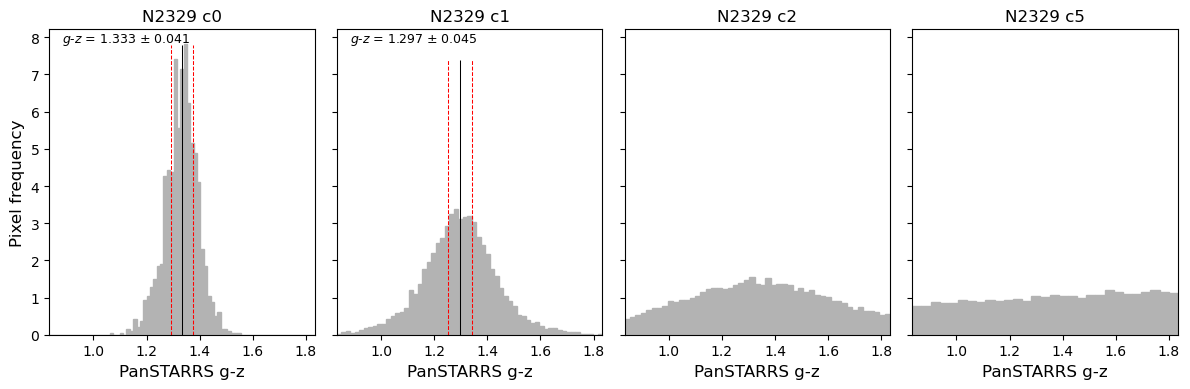

Text(0.5, 1.0, 'N2329 ($g$-$z$) color map')

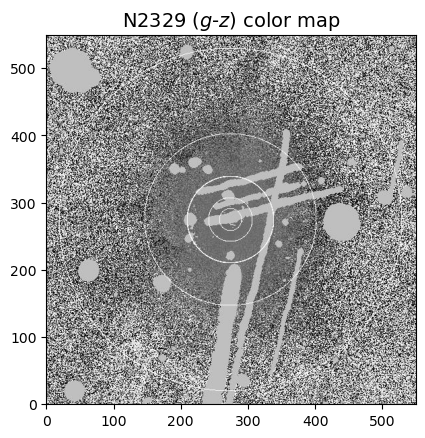

In [22]:
# Plot histograms of the color annuli

# Get stored values output from monsta:
with open(json_name, 'r') as file:
    data = json.load(file)    
name = data["Name"]
color = data["Color"]
colors = [list(d.values())[0] for d in data["g-z"]]
colorsigma = [list(d.values())[0] for d in data["g-z uncertainty"]]
flags = [list(d.values())[0] for d in data["Quality flags"]]

histcolor='0.7'  # histogram color
linewidth=0.75

%matplotlib inline
tmpim0, _ = imOpen(outFolder+"tmpc0.fits")
im0 = tmpim0.flatten()
tmpim1, _ = imOpen(outFolder+"tmpc1.fits")
im1 = tmpim1.flatten()
tmpim2, _ = imOpen(outFolder+"tmpc2.fits")
im2 = tmpim2.flatten()
tmpim3, _ = imOpen(outFolder+"tmpc5.fits")
im3 = tmpim3.flatten()

fig, axes = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(12, 4))
#fig, axes = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

if flags[0]==1:
    ax1.hist(im0, bins=np.linspace(colors[0]-0.5,colors[0]+0.5,80), density=True, color=histcolor, edgecolor=histcolor)
    ax1.set_xlim(colors[0]-0.5, colors[0]+0.5)
    ax1.set_xlabel(color, fontsize=12)
    ax1.set_ylabel("Pixel frequency", fontsize=12)
    ax1.set_title(name.upper()+" c0", fontsize=12)
    xmax = ax1.get_xlim()
    ymax = ax1.get_ylim()   
    title=rf"$g$-$z$ = {colors[0]:.3f} $\pm$ {colorsigma[0]:0.3f}"
    ax1.vlines(colors[0], 0, ymax[1]*0.95, colors='k', linestyles='solid', linewidth=linewidth)
    ax1.vlines(colors[0]+colorsigma[0], 0, ymax[1]*0.95, colors='r', linestyles='dashed', linewidth=0.75)
    ax1.vlines(colors[0]-colorsigma[0], 0, ymax[1]*0.95, colors='r', linestyles='dashed', linewidth=0.75)
    #ax1.legend(loc='upper left', frameon=False, fontsize=9)
    ax1.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')
else:
    ax2.hist(im1, bins=np.linspace(colors[1]-0.5,colors[1]+0.5,60), density=True, color=histcolor, edgecolor=histcolor)
    xmax = ax2.get_xlim()
    ymax = ax2.get_ylim()
    ax1.set_xlabel(color, fontsize=12)
    ax1.set_ylabel("Pixel frequency", fontsize=12)
 
ax2.hist(im1, bins=np.linspace(xmax[0],xmax[1],60), density=True, color=histcolor, edgecolor=histcolor)
ax2.set_xlim(xmax[0],xmax[1])
ax2.set_xlabel(color, fontsize=12)
#ax2.set_ylabel("Pixel frequency", fontsize=12)
ax2.set_title(name.upper()+" c1", fontsize=12)
if flags[1]==1:
    title=rf"$g$-$z$ = {colors[1]:.3f} $\pm$ {colorsigma[1]:0.3f}"
    ax2.vlines(colors[1], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
    ax2.vlines(colors[1]+colorsigma[1], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax2.vlines(colors[1]-colorsigma[1], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    # ax2.legend(loc='upper left', frameon=False, fontsize=9)    
    ax2.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

ax3.hist(im2, bins=np.linspace(xmax[0],xmax[1],50), density=True, color=histcolor, edgecolor=histcolor)
ax3.set_xlim(xmax[0],xmax[1])
ax3.set_xlabel(color, fontsize=12)
#ax3.set_ylabel("Pixel frequency", fontsize=12)
ax3.set_title(name.upper()+" c2", fontsize=12)
if flags[2]==1:
    title=rf"$g$-$z$ = {colors[2]:.3f} $\pm$ {colorsigma[2]:0.3f}"
    ax3.vlines(colors[2], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
    ax3.vlines(colors[2]+colorsigma[2], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax3.vlines(colors[2]-colorsigma[2], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    # ax3.legend(loc='upper left', frameon=False, fontsize=9)
    ax3.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')
    
ax4.hist(im3, bins=np.linspace(xmax[0],xmax[1],30), density=True, color=histcolor, edgecolor=histcolor)
ax4.set_xlim(xmax[0],xmax[1])
ax4.set_xlabel(color, fontsize=12)
#ax4.set_ylabel("Pixel frequency", fontsize=12)
ax4.set_title(name.upper()+" c5", fontsize=12)
if flags[3]==1:
    title=rf"$g$-$z$ = {colors[3]:.3f} $\pm$ {colorsigma[3]:0.3f}"
    ax4.vlines(colors[3], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
    ax4.vlines(colors[3]+colorsigma[3], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax4.vlines(colors[3]-colorsigma[3], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    # ax4.legend(loc='upper left', frameon=False, fontsize=9)
    ax4.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

plt.savefig(outFolder+name+"-PSgzHistogram.pdf", format='pdf', bbox_inches='tight')
plt.show()

ax = plt.gca()
tv(outFolder+name+"gz.zoom.clr",ax=ax, options='0 4')
ax.set_title(name.upper() + r" ($g$-$z$) color map", fontsize=14)


In [23]:
#! cat monsta.log

In [24]:
# print(name)
# ! cat {json_name}

In [25]:
# clean up temporary display images
temp = outFolder+name+'*.zoom.*'
!rm {temp}
temp = outFolder+name+'*.nonan'
!rm {temp}
temp = outFolder+name+'*.resid'
!rm {temp}
# !rm monsta.log
!rm monsta.pro
temp = outFolder+'tmpc*.fits'
!rm {temp}